In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
# Discard Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import os
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
# Print the current directory
cwd = os.getcwd()
print(cwd)

# change the current directory to extract files
os.chdir('/')

# Print the current directory for confirmation
cwd = os.getcwd()
print(cwd)

/content
/


In [5]:
# Import the zip file and extract
import zipfile

with zipfile.ZipFile('/content/data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
# Load balanced.csv and prints begining
df = pd.read_csv("/content/drive/MyDrive/GenderDetection/balanced-all.csv")
df.head()

,filename,gender
0,data/cv-other-train/sample-069205.npy,female
1,data/cv-valid-train/sample-063134.npy,female
2,data/cv-other-train/sample-080873.npy,female
3,data/cv-other-train/sample-105595.npy,female
4,data/cv-valid-train/sample-144613.npy,female


In [7]:
# Load balanced.csv and prints end
df.tail()

,filename,gender
66933,data/cv-valid-train/sample-171098.npy,male
66934,data/cv-other-train/sample-022864.npy,male
66935,data/cv-valid-train/sample-080933.npy,male
66936,data/cv-other-train/sample-012026.npy,male
66937,data/cv-other-train/sample-013841.npy,male


In [8]:
# get total samples
n_samples = len(df)
# get total male samples
n_male_samples = len(df[df['gender'] == 'male'])
# get total female samples
n_female_samples = len(df[df['gender'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)

Total samples: 66938
Total male samples: 33469
Total female samples: 33469


In [9]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("/content/drive/MyDrive/GenderDetection/balanced-all.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [10]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [11]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

Total samples: 66938
Total male samples: 33469
Total female samples: 33469


Loading data: 100%|██████████| 66938/66938 [00:33<00:00, 2012.44it/s]


In [12]:
# Prints the shape of traning, validation and test datasets
print(np.shape(data["X_train"]))
print(np.shape(data["X_valid"]))
print(np.shape(data["X_test"]))

(54219, 128)
(6025, 128)
(6694, 128)


In [13]:
# Installing required packages
!pip install pydub
!pip install noisereduce
!pip install json-tricks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
def create_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [15]:
# construct the model
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [17]:
# Import required libraries
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [18]:
# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

In [19]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
history = model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 17s 16ms/step - loss: 0.5579 - accuracy: 0.7630 - val_loss: 0.3694 - val_accuracy: 0.8473
Epoch 2/100
848/848 [==============================] - 17s 20ms/step - loss: 0.4135 - accuracy: 0.8389 - val_loss: 0.3481 - val_accuracy: 0.8627
Epoch 3/100
848/848 [==============================] - 8s 10ms/step - loss: 0.3765 - accuracy: 0.8539 - val_loss: 0.3215 - val_accuracy: 0.8666
Epoch 4/100
848/848 [==============================] - 11s 13ms/step - loss: 0.3623 - accuracy: 0.8615 - val_loss: 0.3177 - val_accuracy: 0.8802
Epoch 5/100
848/848 [==============================] - 10s 11ms/step - loss: 0.3419 - accuracy: 0.8685 - val_loss: 0.3015 - val_accuracy: 0.8825
Epoch 6/100
848/848 [==============================] - 12s 14ms/step - loss: 0.3398 - accuracy: 0.8713 - val_loss: 0.2854 - val_accuracy: 0.8923
Epoch 7/100
848/848 [==============================] - 11s 12ms/step - loss: 0.3229 - accuracy: 0.8757 - val_loss: 0.2828 - val_acc

In [20]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 6694 samples...
Loss: 0.2350
Accuracy: 91.46%


In [21]:
# Validation score
loss,acc = model.evaluate(data["X_valid"], data["y_valid"], verbose=2)

189/189 - 1s - loss: 0.2297 - accuracy: 0.9125 - 976ms/epoch - 5ms/step


In [22]:
# Importing the relevant libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

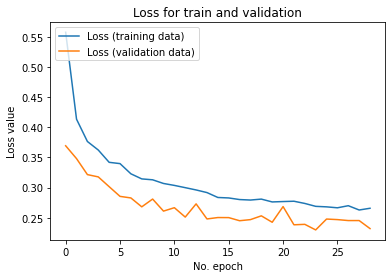

In [23]:
#Loss prediction for trained and validation dataset

plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


In [28]:
# Save the model to a file
model.save("/content/drive/MyDrive/GenderDetection/model.h5")
print(model)

In [29]:
from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/MyDrive/GenderDetection/modelLSTM.json'
saved_weights_path = '/content/drive/MyDrive/GenderDetection/modelLSTM_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


In [30]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.2.2-2.1ubuntu2.5).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 188 kB of archives.
After this operation, 926 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudiocpp0 amd64 19.6.0-1build1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 portaudio19-dev amd64 19.6.0-1build1 [106 kB]
Fetched 188 kB in 0s (741 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 128215 files and directories currently installe

In [31]:
!pip install PyAudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 KB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyAudio: filename=PyAudio-0.2.13-cp38-cp38-linux_x86_64.whl size=69725 sha256=534d0828c9adb6cf06fa6ceb981b348bb5d9eb8e9894fe45cd43a06443fec718
  Stored in directory: /root/.cache/pip/wheels/c9/64/0b/9a483698792349f565ecc45c5ee3f1efb2ce79464f6d9daf53
Successfully built PyAudio


In [57]:
# Checking for External Inputs and Validation
# Retrive the file path
file_name = "/content/drive/MyDrive/VoiceData/1008_IEO_SAD_HI.wav"

In [58]:
# Load file data
import librosa
array, sample_rate = librosa.core.load(file_name)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 256)               33024     
                                                                 
 dropout_60 (Dropout)        (None, 256)               0         
                                                                 
 dense_73 (Dense)            (None, 256)               65792     
                                                                 
 dropout_61 (Dropout)        (None, 256)               0         
                                                                 
 dense_74 (Dense)            (None, 128)               32896     
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 
 dense_75 (Dense)            (None, 128)             

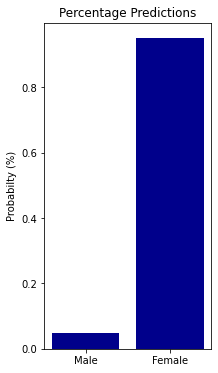

/content/drive/MyDrive/VoiceData/1008_IEO_SAD_HI.wav


In [59]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    # array, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(array))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=array, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(array, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(array), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result


if __name__ == "__main__":
    # load the saved model (after training)
    # model = pickle.load(open("result/mlp_classifier.model", "rb"))
    # from utils import load_data, split_data, create_model
    import argparse
    parser = argparse.ArgumentParser(description="""Gender recognition script, this will load the model you trained, 
                                    and perform inference on a sample you provide (either using your voice or a file)""")
    parser.add_argument("-f", "--file", help="The path to the file, preferred to be in WAV format")
    args = parser.parse_args()
    file = args.file
    # construct the model
    model = create_model()
    # load the saved/trained weights
    model.load_weights("/content/drive/MyDrive/GenderDetection/model.h5")
    features = extract_feature(file, mel=True).reshape(1, -1)
    # predict the gender!
    male_prob = model.predict(features)[0][0]
    female_prob = 1 - male_prob
    gender = "male" if male_prob > female_prob else "female"
    # show the result!
    print("Result:", gender)
    print(f"Probabilities:     Male: {male_prob*100:.2f}%    Female: {female_prob*100:.2f}%")

    # Results Demostration
    gender = ['Male', 'Female']
    Probability = [male_prob, female_prob]
    fig = plt.figure(figsize = (3, 6))
    plt.bar(gender, Probability, color = 'darkblue')
    plt.ylabel("Probabilty (%)")
    plt.title("Percentage Predictions")
    plt.show()

    print(file_name)